In [1]:
from dotenv import load_dotenv
load_dotenv('/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/.env')
%load_ext autoreload
%autoreload 2

def get_aestetics(model):
    MODEL_TO_AESTETICS = {
        'panopticon': ('blue', 'o'),
        'dofa': ('orange', 's'),
        'softcon': ('green', '^'),
        'dino': ('red', 'x'),
        'croma': ('purple', 'D'),
        'senpamae': ('brown', 'P'),
        'senpamae_old': ('brown', 'P'),

    }

    for key, value in MODEL_TO_AESTETICS.items():
        if key in model:
            return value
    raise ValueError(f"Model {model} not found in aesthetics mapping.")

### Build Landsat srfs

In [41]:
import pandas as pd
import os
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/landsat8_srf/'

# load
out = {}
for f in os.listdir(root):
    df = pd.read_csv(os.path.join(root, f), delimiter='\t')
    out[f.split('.')[0]] = df

# process
for k, v in out.items():
    new_out = np.zeros(2400)
    new_out[v['Wavelength']] = v['BARSR[watts]']
    out[k] = new_out

out = np.stack(list(out.values()), axis=0).T
out = out[:2301, :]
print(out.shape)

# save
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/landsat8_srf.npy', out)

(2301, 9)


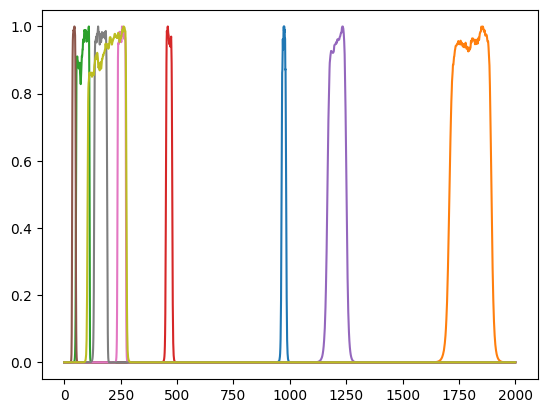

In [38]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(out.shape[0]):
    plt.plot(out[i,400:2400], label=f'Band {i+1}')


### Debug SenpaMAE

In [48]:
from geobreeze.datasets.geobench import GeoBenchDataset
from geobreeze.datasets.base import collate_fn

ds = GeoBenchDataset(
    'm-eurosat',
    split='train',
)


batch = collate_fn([ds[i] for i in range(4)])
batch[0]['gsd'].shape


/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 13])

In [49]:
batch[0]['chn_ids'].shape

torch.Size([4, 13])

In [37]:
import torch
batch = torch.utils.data.default_collate([ds[i] for i in range(4)])

batch[0]['band_ids']

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

In [35]:
ds[0][0]['band_ids']

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
import torch

x = torch.ones((2,3,4))
x[0].shape

torch.Size([3, 4])

In [2]:
import numpy as np
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
arr = np.load(os.path.join(root,'rfs_sentinel2_a_13b.npy'))
arr.shape

(2301, 13)

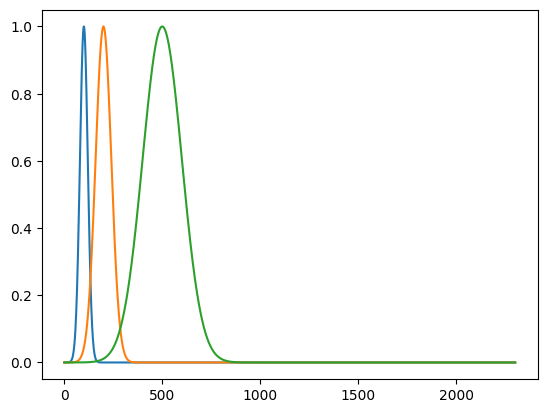

In [28]:
from torch import Tensor
import torch

def _create_srf_from_mu_std(mus: Tensor, sigmas: Tensor):
    assert mus.shape[0] == sigmas.shape[0]
    x_min, x_max = 0, 2301
    x = torch.linspace(x_min, x_max, 2301).unsqueeze(0).to(mus.device)
    vals = torch.exp(-0.5 * ((x - mus.unsqueeze(1)) / sigmas.unsqueeze(1)) ** 2)
    vals = vals / vals.max(dim=1, keepdim=True)[0]
    return vals

vals = _create_srf_from_mu_std(
    torch.tensor([100, 200, 500]),
    torch.tensor([20, 40, 100])
)

vals.shape

import matplotlib.pyplot as plt

plt.figure()
for i in range(vals.shape[0]):
    plt.plot(vals[i,:], label=f'Band {i+1}')


In [27]:
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
p = 'rfs_landsat.npy'
arr = np.load(os.path.join(root,p))
print(arr.shape)
indices = np.argmax(arr, axis=0)
for i in indices:
    print(i)

(2301, 7)
145
209
250
356
559
1333
1955


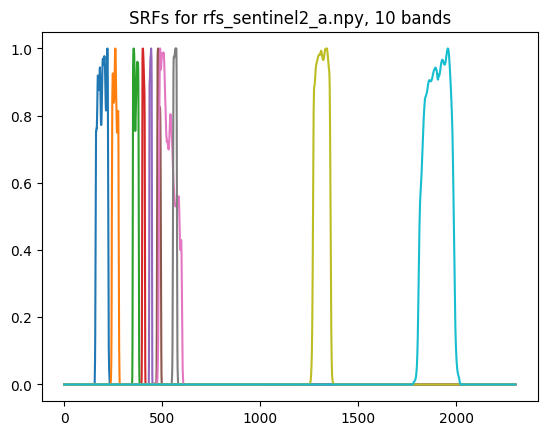

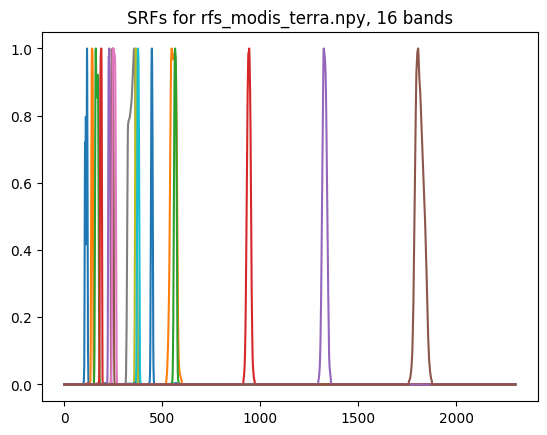

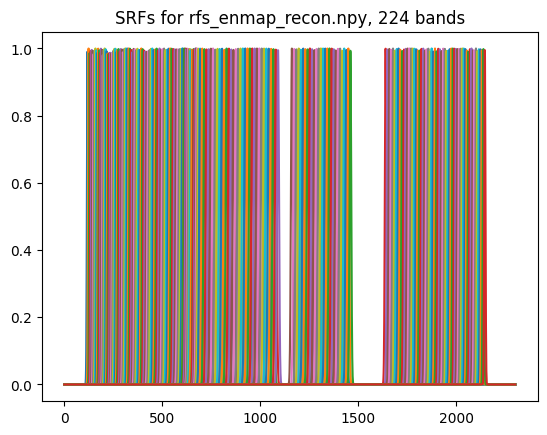

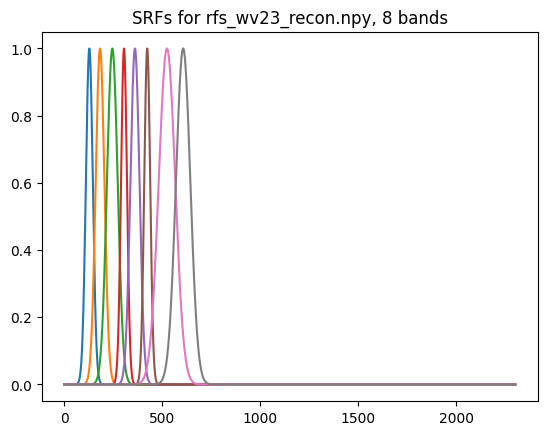

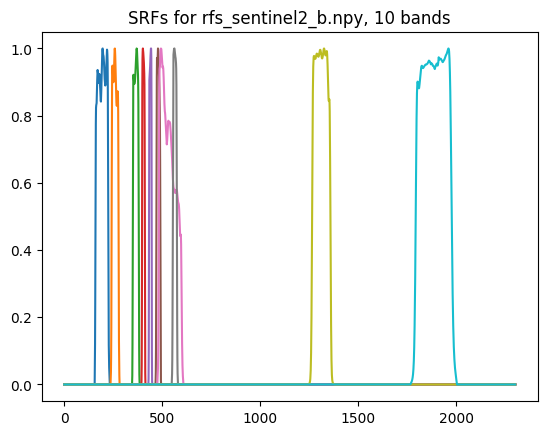

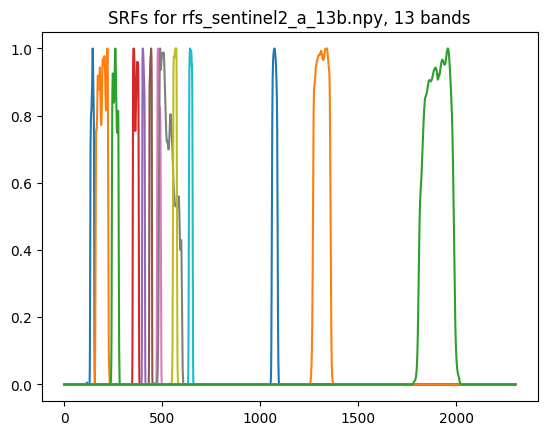

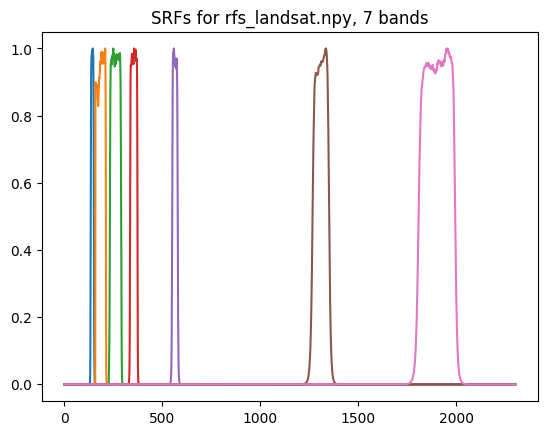

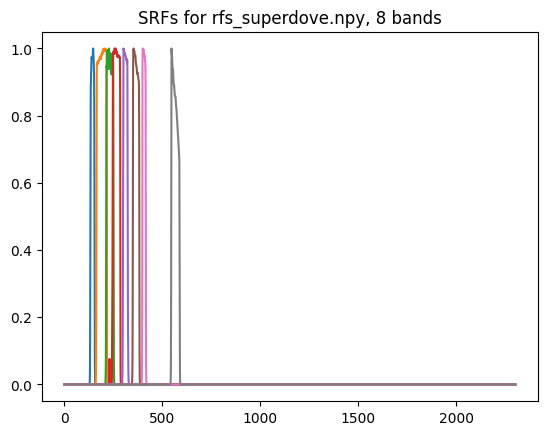

In [6]:
import matplotlib.pyplot as plt

for f in os.listdir(root):
    if not f.endswith('.npy'):
        continue

    arr = np.load(os.path.join(root, f))
    plt.figure()
    for i in range(arr.shape[1]):
        plt.plot(arr[:, i], label=f'Band {i+1}')
    plt.title(f'SRFs for {f}, {arr.shape[1]} bands')

### Cross Sensor

In [22]:
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor'
collect_csv(p)
df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])
df['relpath'] = df['relpath'].apply(lambda x: x.replace('_rgb/','/'))
df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[1])
df['train_ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[-2])

df['test_ds'] = ''
for i in range(len(df)):
    test_ds_idx = int(df.iloc[i]['metric'].split('_')[-1])
    test_datasets = df.iloc[i]['relpath'].split('/')[0].split('_')[-2:]
    df['test_ds'][i] = test_datasets[test_ds_idx]

df['ds_str'] = df['train_ds'] + '->' + df['test_ds']
df['metric'] = df['metric'].apply(lambda x: x.split('_')[0])
df = df[df['metric'].isin(['acc','MSE'])]
df = df.groupby(['model','ds','ds_str','metric','train_ds','test_ds']).agg({'val': 'max'}).reset_index()
# display(df)

# add normalization
norms = {}
for i in range(len(df)):
    if df.iloc[i]['train_ds'] == df.iloc[i]['test_ds']:
        key = (df.iloc[i]['model'], df.iloc[i]['ds'], df.iloc[i]['train_ds'])
        val = df.iloc[i]['val']
        norms[key] = val

df['base_val'] = pd.Series([norms[model,ds,sens] 
        for model,ds,sens in zip(df['model'],df['ds'], df['train_ds'])])  
df['prc'] = df['val'] / df['base_val']

# everything absolute
# for metric in df['metric'].unique():
#     dfprint = df[df['metric'] == metric]
#     print(metric)
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     display(dfprint)


# only diff
# for metric in df['metric'].unique():
#     print(metric)
#     dfprint = df[df['metric'] == metric]
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     dfprint['MD->SD (prc)'] = dfprint['MD->SD'] / dfprint['MD->MD']
#     dfprint['SD->MD (prc)'] = dfprint['SD->MD'] / dfprint['SD->SD']
#     display(dfprint)


df['ds_str'] = df['ds'] + ':' + df['ds_str']
df = df[df['train_ds'] != df['test_ds']]

dfcls = df[df['metric'] == 'acc']
dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)
dfcls = dfcls.pivot(index='model', columns='ds_str', values='prc')
display(dfcls)

dfreg = df[df['metric'] == 'MSE']
dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)
dfreg = dfreg.pivot(index='model', columns='ds_str', values='prc')
display(dfreg)

/scratch/ipykernel_2811788/3032963934.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_ds'][i] = test_datasets[test_ds_idx]
/scratch/ipykernel_2811788/3032963934.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)


ds_str,eurosat:s1->s2,eurosat:s2->s1,so2sat:s1->s2,so2sat:s2->s1
model,,,,
dinov2,NaN,NaN,-73.9,-80.7
dofa,-77.5,-73.3,-63.2,-82.8
panopticon,-50.2,-48.2,-73.8,-86.2


/scratch/ipykernel_2811788/3032963934.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)


ds_str,hypv:MD->SD,hypv:SD->MD
model,,
dinov2,-0.4,0.6
dofa,-2.7,8.8
panopticon,1.0,0.2


### Debug Hyperview

In [21]:
""" get indices"""
import yaml
import torch

sats = {
    'SD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/superdove.yaml',
    'MD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/modis_terra.yaml',
    'hyperview': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml',
}

for k,v in sats.items():
    with open(v, 'r') as f:
        data = yaml.safe_load(f)
    sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands'].values()])

def find(src, tgt):
    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src)
    if not isinstance(tgt, torch.Tensor):
        tgt = torch.tensor(tgt)
    src = src[:, None]
    tgt = tgt[None, :]
    diff = torch.abs(src - tgt)
    min_diff, min_idx = diff.min(dim=0)
    return min_idx, min_diff

# find(sats['hyperview'], sats['MD'])

find(sats['hyperview'], [665.69,554,487])

(tensor([64, 29,  8]), tensor([0.9700, 0.7800, 0.6500]))

In [19]:
from geobreeze.datasets.utils.utils import load_ds_cfg

dsconfig = load_ds_cfg('hyperview')

MD = [1,8,21,27,29,57,64,67,89,124,127]
SD = [9,22,32,47,64,77,126]

SD_rgb = [63, 32,  9]

dsconfig = load_ds_cfg('hyperview')
for i in SD_rgb:
    print(dsconfig['bands'][i]['gaussian']['mu'])



663.46
564.37
490.85


In [19]:
from geobreeze.datasets import Hyperview
import os

for split in ['train','val','test']:

    ds = Hyperview(
        root = os.path.expandvars('$DATASETS_DIR/hyperview'),
        split = split,
        do_mask = False,
    )

    print(f"Split: {split}")
    print(f"Number of samples: {len(ds)}")

[HyperviewBenchmark] Building dataset for split: train
Split: train
Number of samples: 1298
[HyperviewBenchmark] Building dataset for split: val
Split: val
Number of samples: 174
[HyperviewBenchmark] Building dataset for split: test
Split: test
Number of samples: 260


In [20]:
OmegaConf.load(p).data.test

[{'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [9, 22, 32, 47, 64, 77, 126]}, {'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [1, 8, 21, 27, 29, 57, 64, 67, 8, 124, 127]}]

In [11]:
ds

In [ ]:
from geobreeze.factory import 

In [21]:
for xdict,_ in ds:
    print(xdict['imgs'].shape)

pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 43, 42])
post transform torch.Size([150, 43, 42])
torch.Size([150, 43, 42])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 125, 124])
post transform torch.Size([150, 125, 124])
torch.Size([150, 125, 124])
pre transform torch.Size([150, 42, 42])
post transform torch.Size([150, 42, 42])
torch.Size([150, 42, 42])
pre transform torch.Size([150, 104, 120])
post transform torch.Size([150, 104, 120])
torch.Size([150, 104, 120])
pre transform torch.Size([150, 40, 44])
post transform torch.Size([150, 40, 44])
torch.Size([150, 40, 44])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size(

KeyboardInterrupt: 

In [3]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
cfg = OmegaConf.load(p)

trf_list = make_transform_list(cfg.data.train.transform)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

cfg: _target_: <class 'str'>, kornia.augmentation.RandomHorizontalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomVerticalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomResizedCrop
cfg: size: <class 'list'>, [224, 224]
cfg: scale: <class 'list'>, [0.8, 1.0]


TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [10]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

cfg = OmegaConf.create([{
    '_target_': 'RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

trf_list = make_transform_list(cfg)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [8]:
import hydra
import kornia.augmentation as K

cfg = OmegaConf.create([{
    '_target_': 'kornia.augmentation.RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

cfg = OmegaConf.to_container(cfg, resolve=True)
cfg = cfg[0]

cfg.pop('_target_')
trf = K.RandomResizedCrop(**cfg)

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [42]:
img = torch.randn(1, 3, 553, 12)

trf(img).shape

TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [39]:
import torch
import kornia.augmentation as K

trf = K.AugmentationSequential(
    # K.CenterCrop(size=224),
    # K.Resize(size=(224, 224), align_corners=False),
    K.RandomResizedCrop(size=[224,224], scale=[0.08,1.0])
)


img = torch.randn(1, 3, 553, 12)

trf(img).shape

torch.Size([1, 3, 224, 224])

In [16]:
from omegaconf import OmegaConf
from geobreeze.factory import make_dataset
from torch.utils.data import DataLoader

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
ds = make_dataset(OmegaConf.load(p).data.train)



dl = DataLoader(
    ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

for i, batch in enumerate(dl):
    print(i)
    print(batch['imgs'].shape)
    break

INFO:eval:Subsampled 7/150 bands with ids [9, 22, 32, 47, 64, 77, 126]. Band names are:
  000: B010
  001: B023
  002: B033
  003: B048
  004: B065
  005: B078
  006: B127


{'_target_': 'kornia.augmentation.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}
[HyperviewBenchmark] Building dataset for split: train
Got subset=100, subsampled dataset to #samples 100 


RuntimeError: stack expects each tensor to be equal size, but got [7, 229, 224] at entry 0 and [7, 224, 224] at entry 1

In [16]:
ds[idx][0]['imgs']

tensor([[[-8.8704e-01, -1.1546e+00, -1.5263e+00,  ...,  4.3612e-01,
           4.2868e-01,  2.8001e-01],
         [-1.0580e+00, -4.4847e-01, -1.5263e+00,  ..., -4.7061e-02,
           5.7008e-02,  2.7258e-01],
         [-9.1678e-01, -3.2210e-01, -1.0134e+00,  ..., -1.3626e-01,
          -1.0653e-01, -1.2140e-01],
         ...,
         [-2.4776e-01, -2.1803e-01, -1.5113e-01,  ...,  4.1382e-01,
           4.9558e-01,  4.5098e-01],
         [-2.5520e-01, -1.9573e-01, -4.7061e-02,  ...,  4.8815e-01,
           6.6655e-01,  7.1115e-01],
         [-2.4033e-01, -2.1060e-01, -2.8493e-01,  ...,  3.7665e-01,
           4.5098e-01,  4.7328e-01]],

        [[-8.2398e-01, -1.1288e+00, -1.4931e+00,  ...,  4.6228e-01,
           3.8793e-01,  3.5075e-01],
         [-1.0173e+00, -4.4479e-01, -1.5006e+00,  ..., -8.7912e-02,
           1.3078e-03,  2.0205e-01],
         [-8.9833e-01, -3.1840e-01, -9.6524e-01,  ..., -1.1022e-01,
          -1.1765e-01, -1.3252e-01],
         ...,
         [-2.7379e-01, -2

In [13]:
for idx in range(100):
    print(ds[idx][0]['imgs'].shape)

torch.Size([150, 11, 11])
torch.Size([150, 43, 42])
torch.Size([150, 11, 11])
torch.Size([150, 125, 124])
torch.Size([150, 42, 42])
torch.Size([150, 104, 120])
torch.Size([150, 40, 44])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 125, 136])
torch.Size([150, 11, 11])
torch.Size([150, 108, 92])
torch.Size([150, 11, 11])
torch.Size([150, 46, 47])
torch.Size([150, 11, 11])
torch.Size([150, 124, 123])
torch.Size([150, 11, 11])
torch.Size([150, 126, 125])
torch.Size([150, 43, 42])
torch.Size([150, 117, 119])
torch.Size([150, 25, 71])
torch.Size([150, 11, 11])
torch.Size([150, 30, 42])
torch.Size([150, 184, 110])
torch.Size([150, 148, 125])
torch.Size([150, 35, 38])
torch.Size([150, 11, 11])
torch.Size([150, 46, 48])
torch.Size([150, 43, 42])
torch.Size([150, 70, 129])
torch.Size([150, 42, 42])
torch.Size([150, 11, 11])
torch.Size([150, 111, 110])
torch.Size([150, 46, 48])
torch.Size([150, 1

In [9]:
ds.dataset.df['file_paths'].apply(lambda x: x.split('/')[-3:])

0       [hyperview, train_data, 364.npz]
1       [hyperview, train_data, 945.npz]
2       [hyperview, train_data, 596.npz]
3      [hyperview, train_data, 1353.npz]
4       [hyperview, train_data, 955.npz]
                     ...                
255    [hyperview, train_data, 1258.npz]
256     [hyperview, train_data, 284.npz]
257    [hyperview, train_data, 1360.npz]
258    [hyperview, train_data, 1135.npz]
259    [hyperview, train_data, 1322.npz]
Name: file_paths, Length: 260, dtype: object

### Create large eval table 

In [31]:
import pandas as pd

def get_alldf():
    p = '/home/hk-project-pai00028/tum_mhj8661/code/table2.csv'
    table2_df = pd.read_csv(p)
    table2_df = table2_df[['benv2-s2','benv2-s1','RESISC45']]

    p = '/home/hk-project-pai00028/tum_mhj8661/code/table_generalization.csv'
    generalization_df = pd.read_csv(p)
    generalization_df = generalization_df.drop(index=['DINOv2-PE','Croma-PE','Softcon-PE','Anysat-PE',])

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_cls.csv'
    gb_cls = pd.read_csv(p)
    gb_cls.drop(columns=['benv2-s2'], inplace=True)
    gb_cls.rename(columns={'m-pv4ger': 'm-pv4ger-cls'}, inplace=True)

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_segm.csv'
    gb_segm = pd.read_csv(p)
    gb_segm.rename(columns={'m-pv4ger': 'm-pv4ger-seg'}, inplace=True)

    return pd.concat([table2_df, generalization_df, gb_cls, gb_segm], axis=1)

all_df = get_alldf()
all_df

,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,...,m-eurosat,m-forestnet,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop
DINOv2,80.1,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.5,53.5,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.1,NaN,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.2,NaN,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.6,50.9,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.6,NaN,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,...,77.5,33.5,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3
DOFA,78.8,72.0,92.0,89.9,42.0,63.9,65.8,0.334,0.338,0.385,...,92.9,53.2,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,...,96.4,56.3,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6


In [34]:
""" get new results """
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

cls_dir = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/fmplayground/t1_v3/'
collect_csv(cls_dir)

def map_dsname(name: str):
    if 'benv2' in name:
        name = name.replace('rgb','s2')
        return '_'.join(name.split('_')[:2])
    elif 'corine' in name:
        return name
    elif 'geobench' in name:
        name = name.removeprefix('geobench_')
        name = name.replace('brick_kiln','brickkiln')

    return name.split('_')[0]

def map_modelname(name: str):
    name = name.split('_')[0]
    name_to_papername = {
        'dinov2': 'DINOv2',
        'croma': 'CROMA',
        'softcon': 'SoftCon',
        'dofa': 'DOFA',
        'panopticon': 'Panopticon',
        'galileo': 'Galileo',
        'senpamae': 'SenPaMAE',
        'anysat': 'Anysat',
    }
    return name_to_papername[name]

def get_newdf():
    p = os.path.join(cls_dir, 'results.csv')
    df = pd.read_csv(p).drop(columns=['Unnamed: 0'])
    df['_ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['_model'] = df['relpath'].apply(lambda x: x.split('/')[2])
    df = df[ ~ df['_model'].isin(['panopticon_chnsim','panopticon_v2','panopticon_v4']) ]
    df['ds'] = df['_ds'].apply(lambda x: map_dsname(x))
    df['model'] = df['_model'].apply(lambda x: map_modelname(x))
    df = df[ df['metric'].isin(['acc_top-1_micro','MulLabAvergPrec_micro'])]

    df = df.groupby(['model','ds']).agg({'val': 'max'}).reset_index()

    df = df.pivot(index='model', columns='ds', values='val')
    df = round(df*100, 1)
    index_order = ['DINOv2', 'CROMA', 'SoftCon', 'AnySat', 'Galileo', 'SenPaMAE', 'DOFA',
        'Panopticon']
    return df.reindex(index_order)

newdf = get_newdf()
newdf

ds,benv2_s1,benv2_s2,brickkiln,eurosat,eurosat-sar,fmow,forestnet,m-so2sat-s1,pv4ger,resisc45,so2sat
model,,,,,,,,,,,
DINOv2,NaN,80.1,97.5,95.5,95.3,47.0,53.5,30.0,97.5,94.0,60.8
CROMA,74.5,79.4,94.5,91.1,85.6,NaN,NaN,27.6,NaN,NaN,53.5
SoftCon,80.0,84.3,94.9,92.2,88.4,NaN,NaN,28.5,NaN,NaN,52.1
AnySat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Galileo,70.3,76.5,93.1,88.6,NaN,NaN,NaN,NaN,NaN,NaN,54.2
SenPaMAE,NaN,63.8,83.9,77.5,NaN,16.9,33.5,NaN,87.1,28.2,33.7
DOFA,72.0,78.8,95.8,92.9,89.1,42.0,53.2,26.8,97.4,92.0,54.2
Panopticon,78.4,83.9,96.7,96.4,97.0,50.3,56.3,32.2,96.4,90.9,61.7


In [37]:
""" build table """
import yaml 

def merge(cols=['m-so2sat-s1', 'eurosat-sar']):
    all_df = get_alldf()
    new_df = get_newdf()
    new_results = new_df[cols]

    return pd.concat([all_df, new_results], axis=1)

all_df = merge()

p = '/home/hk-project-pai00028/tum_mhj8661/code/tasks.yaml'
with open(p) as f:
    ds_to_tasks = yaml.safe_load(f)

# add cross terms
cross_terms = ds_to_tasks.pop('_cross_terms', {})
for ds, ids in ds_to_tasks.items():
    for item in cross_terms:
        assert len(item.keys()) == 1
        assert len(item.values()) == 1 
        c_name = list(item.keys())[0]
        c_ids = list(item.values())[0]
        if all([c in ids for c in c_ids]):
            ds_to_tasks[ds].append(c_name)

# process
group_ids = set()
for groups in ds_to_tasks.values():
    for id in groups:
        group_ids.add(id)

df = pd.DataFrame(index=all_df.index)
for id in group_ids:
    agg = []
    print('GROUP ', id)
    for ds, groups in ds_to_tasks.items():
        if id in groups and ds in all_df.columns:
            print('  ', ds)
            agg.append(all_df[ds])
    agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
    df[id] = agg

printdf = df[['all','all_linprobe','all_segm','linprob_s2','linprob_s1','linprob_rgb','segm_s2','segm_rgb','rgb','s2','s1']]
display(printdf)

printdf = df[['all','all_linprobe','all_segm','rgb','s2','s1','others']]
display(printdf)

printdf.columns = [c.replace('_','-') for c in printdf.columns]
print(printdf.round(1).style.format(precision=1).highlight_max(axis=0, props='textbf:--rwrap;').to_latex())

GROUP  linprob_s2
   benv2-s2
   m-brick-kiln
   m-eurosat
   m-so2sat
GROUP  rgbn
   m-chesapeake
GROUP  Himawari
   DT
GROUP  s1
   benv2-s1
   m-so2sat-s1
   eurosat-sar
GROUP  wv7
   SpaceNet1
GROUP  all_segm
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  l8
   m-forestnet
GROUP  bench
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-pv4ger-cls
   m-so2sat
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  rgb
   RESISC45
   m-neontree
   m-nzcattle
   m-pv4ger-seg
GROUP  segm_rgb
   m-neontree
   m-nzcattle
   m-pv4ger-seg
GROUP  gb_cls
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-so2sat
GROUP  all
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   Corine-SD
   Corine-MD
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-pv4ger-cls
   m-so2sat
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
   m-

/scratch/ipykernel_2864705/3226486105.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_2864705/3226486105.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_2864705/3226486105.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_

,all,all_linprobe,all_segm,linprob_s2,linprob_s1,linprob_rgb,segm_s2,segm_rgb,rgb,s2,s1
DINOv2,NaN,NaN,77.7,83.5,NaN,94.0,58.6,90.2,91.1,75.2,NaN
CROMA,NaN,NaN,NaN,79.6,61.2,NaN,46.3,NaN,NaN,68.5,61.2
SoftCon,NaN,NaN,NaN,80.9,65.6,NaN,52.9,NaN,NaN,71.6,65.6
AnySat,NaN,NaN,69.8,74.0,NaN,65.5,39.2,88.1,82.4,62.4,NaN
Galileo,NaN,NaN,NaN,78.1,NaN,NaN,40.0,NaN,NaN,65.4,NaN
SenPaMAE,NaN,NaN,64.5,64.7,NaN,28.2,40.0,82.4,68.9,56.5,NaN
DOFA,75.1,74.8,75.9,80.4,62.6,92.0,53.8,89.8,90.4,71.6,62.6
Panopticon,79.5,80.9,76.2,84.7,69.2,90.9,56.0,89.1,89.6,75.1,69.2


,all,all_linprobe,all_segm,rgb,s2,s1,others
DINOv2,NaN,NaN,77.7,91.1,75.2,NaN,NaN
CROMA,NaN,NaN,NaN,NaN,68.5,61.2,NaN
SoftCon,NaN,NaN,NaN,NaN,71.6,65.6,NaN
AnySat,NaN,NaN,69.8,82.4,62.4,NaN,NaN
Galileo,NaN,NaN,NaN,NaN,65.4,NaN,NaN
SenPaMAE,NaN,NaN,64.5,68.9,56.5,NaN,68.6
DOFA,75.1,74.8,75.9,90.4,71.6,62.6,73.2
Panopticon,79.5,80.9,76.2,89.6,75.1,69.2,87.4


\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & nan & nan & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & nan & nan \\
CROMA & nan & nan & nan & nan & 68.5 & 61.2 & nan \\
SoftCon & nan & nan & nan & nan & 71.6 & 65.6 & nan \\
AnySat & nan & nan & 69.8 & 82.4 & 62.4 & nan & nan \\
Galileo & nan & nan & nan & nan & 65.4 & nan & nan \\
SenPaMAE & nan & nan & 64.5 & 68.9 & 56.5 & nan & 68.6 \\
DOFA & 75.1 & 74.8 & 75.9 & 90.4 & 71.6 & 62.6 & 73.2 \\
Panopticon & \textbf{79.5} & \textbf{80.9} & 76.2 & 89.6 & 75.1 & \textbf{69.2} & \textbf{87.4} \\
\end{tabular}



In [6]:
all_df['RESISC45']

DINOv2        94.0
CROMA          NaN
SoftCon        NaN
AnySat        65.5
Galileo        NaN
SenPaMAE      28.2
DOFA          92.0
Panopticon    90.9
Name: RESISC45, dtype: float64

\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & nan & nan & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & nan & nan \\
CROMA & nan & nan & nan & nan & 68.5 & 70.3 & nan \\
SoftCon & nan & nan & nan & nan & 71.6 & \textbf{80.0} & nan \\
AnySat & nan & nan & 69.8 & 82.4 & 62.4 & 64.4 & nan \\
Galileo & nan & nan & nan & nan & 65.4 & 70.3 & nan \\
SenPaMAE & nan & nan & 64.5 & 68.9 & 56.5 & nan & 68.6 \\
DOFA & 76.3 & 77.8 & 75.9 & 90.4 & 71.6 & 72.0 & 73.2 \\
Panopticon & \textbf{80.6} & \textbf{83.9} & 76.2 & 89.6 & 75.1 & 78.4 & \textbf{87.4} \\
\end{tabular}



In [30]:
df = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/thesis - Sheet6.csv')
df.index = range(1, len(df)+1)
df = df[['name','source','sensor','#nchns','task','#classes']]
display(df)
print(df.to_latex())

,name,source,sensor,#nchns,task,#classes
1,RESISC45,NaN,RGB,3,cls,45
2,m-pv4ger-cls,NaN,RGB,3,cls,2
3,m-chesapeake,NaN,RGBN,4,segm,4
4,m-neontree,NaN,RGB,3,segm,2
5,m-nzcattle,NaN,RGB,3,segm,2
6,m-pv4ger-seg,NaN,RGB,3,segm,2
7,benv2-s2,BigEarthNet-v2,S2,13,cls,19
8,m-sacrop,NaN,S2,13,segm,10
9,m-so2sat-s2,NaN,S2,10,cls,17
10,m-cashew,NaN,S2,13,segm,7


\begin{tabular}{llllrlr}
\toprule
{} &          name &          source &     sensor &  \#nchns &  task &  \#classes \\
\midrule
1  &      RESISC45 &             NaN &        RGB &       3 &   cls &        45 \\
2  &  m-pv4ger-cls &             NaN &        RGB &       3 &   cls &         2 \\
3  &  m-chesapeake &             NaN &       RGBN &       4 &  segm &         4 \\
4  &    m-neontree &             NaN &        RGB &       3 &  segm &         2 \\
5  &    m-nzcattle &             NaN &        RGB &       3 &  segm &         2 \\
6  &  m-pv4ger-seg &             NaN &        RGB &       3 &  segm &         2 \\
7  &      benv2-s2 &  BigEarthNet-v2 &         S2 &      13 &   cls &        19 \\
8  &      m-sacrop &             NaN &         S2 &      13 &  segm &        10 \\
9  &   m-so2sat-s2 &             NaN &         S2 &      10 &   cls &        17 \\
10 &      m-cashew &             NaN &         S2 &      13 &  segm &         7 \\
11 &  m-brick-kiln &        GeoBench &    

/scratch/ipykernel_2864705/3485080676.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


### Debug eurosat-sar, so2sat-s1

In [18]:
from geobreeze.datasets import GeoBenchDataset, EurosatSAR

ds = GeoBenchDataset(
    ds_name = 'm-so2sat',
    split = 'train',
    band_ids=[0,4,4]
)
ds[0][0]['imgs'].shape



INFO:eval:Subsampled 3/18 bands with ids [0, 4, 4]. Band names are:
  000: 01 - VH.Real
  001: 03 - VV.Real
  002: 03 - VV.Real


torch.Size([3, 32, 32])

In [19]:
ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train')

NameError: name 'EurosatSAR' is not defined

In [2]:
import torch

model = torch.hub.load('Panopticon-FM/panopticon','panopticon_vitb14')
x_dict = dict(
  imgs = torch.randn(2, 3, 112, 112),  # (B, C, H, W)
  chn_ids = torch.tensor([[664, 559, 493]]).repeat(2,1)  # (B, C), RGB wavelengths in nm
)

# get image-level features (for classification, regression, ...)
normed_cls_token = model(x_dict)

Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/Panopticon-FM_panopticon_main
100%|██████████| 378M/378M [00:00<00:00, 480MB/s] 


In [46]:
ds[0]

({'imgs': tensor([[[ 3.0698e-02,  4.6483e-01, -1.6225e-01,  ...,  9.4702e-01,
            -7.7310e-01,  5.2904e-01],
           [ 1.4619e-02,  4.4875e-01,  3.0698e-02,  ..., -4.9981e-01,
             5.1297e-01,  1.9145e-01],
           [ 5.1307e-01,  3.8443e-01, -5.1598e-01,  ...,  1.4616e-02,
            -3.7120e-01, -3.7120e-01],
           ...,
           [-8.1851e-02, -8.8575e-01, -5.9634e-01,  ..., -4.0334e-01,
            -1.5446e+00,  1.2363e+00],
           [ 1.1240e+00, -8.8575e-01, -1.7832e-01,  ..., -1.0785e+00,
             3.2004e-01,  7.8914e-02],
           [ 8.0245e-01,  7.7028e-01, -5.1595e-01,  ...,  7.0584e-01,
             2.5574e-01,  1.2524e+00]],
  
          [[-7.5998e-01, -7.1082e-01, -7.3540e-01,  ..., -4.7484e-01,
            -4.0601e-01, -3.9617e-01],
           [-7.2557e-01, -7.7965e-01, -8.1161e-01,  ..., -4.6992e-01,
            -5.7562e-01, -5.6087e-01],
           [-6.5920e-01, -7.6982e-01, -8.4110e-01,  ..., -4.2321e-01,
            -5.9529e-01, -5.95

In [47]:
ds.ds_config

{'ds_name': 'm-so2sat', 'bands': [{'name': '01 - VH.Real', 'gaussian': {'mu': -2, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B02'}, {'name': '02 - Blue', 'gaussian': {'mu': 492.9971095687347, 'sigma': 23.810316659477703}, 'GSD': 10, 'id': 'sentinel2/B02'}, {'name': '02 - VH.Imaginary', 'gaussian': {'mu': 0}}, {'name': '03 - Green', 'gaussian': {'mu': 559.5987534818435, 'sigma': 12.768882177939654}, 'GSD': 10, 'id': 'sentinel2/B03'}, {'name': '03 - VV.Real', 'gaussian': {'mu': -1, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B01'}, {'name': '04 - Red', 'gaussian': {'mu': 664.6300422881802, 'sigma': 11.757355524910432}, 'GSD': 10, 'id': 'sentinel2/B04'}, {'name': '04 - VV.Imaginary', 'gaussian': {'mu': 0}}, {'name': '05 - VH.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '05 - Vegetation Red Edge', 'gaussian': {'mu': 704.0059319834206, 'sigma': 5.362493403740522}, 'GSD': 20, 'id': 'sentinel2/B05'}, {'name': '06 - VV.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '06 - Vegetatio

In [48]:
for i, b in enumerate(ds.ds_config['bands']):
    print(f"{i}: {b['name']}")

0: 01 - VH.Real
1: 02 - Blue
2: 02 - VH.Imaginary
3: 03 - Green
4: 03 - VV.Real
5: 04 - Red
6: 04 - VV.Imaginary
7: 05 - VH.LEE Filtered
8: 05 - Vegetation Red Edge
9: 06 - VV.LEE Filtered
10: 06 - Vegetation Red Edge
11: 07 - VH.LEE Filtered.Real
12: 07 - Vegetation Red Edge
13: 08 - NIR
14: 08 - VV.LEE Filtered.Imaginary
15: 08A - Vegetation Red Edge
16: 11 - SWIR
17: 12 - SWIR


In [14]:
import geobench

task_iter = geobench.task_iterator(benchmark_name='classification_v1.0')
tasks = {task.dataset_name: task for task in task_iter}
task = tasks.get('m-forestnet')


In [15]:
print(tasks.keys())

dict_keys(['m-forestnet', 'm-bigearthnet', 'm-brick-kiln', 'm-pv4ger', 'm-so2sat', 'm-eurosat'])


In [19]:
task.get_dataset()[0].bands

[Band(info=Band 04 - Red (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 03 - Green (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 02 - Blue (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 05 - NIR (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 06 - SWIR1 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 07 - SWIR2 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01)]

In [19]:
ds = task.get_dataset()
ds.band_stats

{'01 - VH.Real': <geobench.dataset.Stats at 0x145ab082e150>,
 '02 - Blue': <geobench.dataset.Stats at 0x145ab014f410>,
 '02 - VH.Imaginary': <geobench.dataset.Stats at 0x145ab014c250>,
 '03 - Green': <geobench.dataset.Stats at 0x145ab014f650>,
 '03 - VV.Real': <geobench.dataset.Stats at 0x145ab014c410>,
 '04 - Red': <geobench.dataset.Stats at 0x145ab014f710>,
 '04 - VV.Imaginary': <geobench.dataset.Stats at 0x145ab014f090>,
 '05 - VH.LEE Filtered': <geobench.dataset.Stats at 0x145ab014f9d0>,
 '05 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014d910>,
 '06 - VV.LEE Filtered': <geobench.dataset.Stats at 0x145ab014c150>,
 '06 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014ff90>,
 '07 - VH.LEE Filtered.Real': <geobench.dataset.Stats at 0x145ab014fcd0>,
 '07 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014f450>,
 '08 - NIR': <geobench.dataset.Stats at 0x145ab014c1d0>,
 '08 - VV.LEE Filtered.Imaginary': <geobench.dataset.Stats at 0x145ab014f5d0>,
 '08A

In [40]:
band_names = ['VH.Real', '02 - Blue', '03 - Green', 'VV.Real', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']

for b in band_names:
    print(b)
    task.get_dataset(band_names=[b])

VH.Real


TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
task.get_dataset

In [38]:
for split in ['train','valid','test']:
    ds = task.get_dataset(split=split)
    print(ds.normalization_stats())

([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])


In [22]:
sample = ds[0]
x, band_names = sample.pack_to_3d(
            band_names=None,
            resample=False,
            fill_value=None,
            resample_order=3,
        )  # h,w,c
print(band_names)
x.shape

['01 - VH.Real', '02 - VH.Imaginary', '03 - VV.Real', '04 - VV.Imaginary', '05 - VH.LEE Filtered', '06 - VV.LEE Filtered', '07 - VH.LEE Filtered.Real', '08 - VV.LEE Filtered.Imaginary', '02 - Blue', '03 - Green', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']


(32, 32, 18)

In [4]:
from geobreeze.datasets.eurosat_sar import EurosatSAR

ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train',
)
ds[0]

({'imgs': tensor([[[-2.7080e-01, -5.4614e-01, -3.7763e-01,  ..., -7.2110e-02,
            -1.4928e-01, -4.2704e-01],
           [-1.5654e-01, -3.1059e-01, -7.5464e-01,  ...,  2.7207e-01,
            -3.3467e-02, -4.5046e-01],
           [-1.1821e-02, -1.0553e-04, -2.6918e-01,  ...,  1.9445e-01,
            -7.8714e-03, -5.4175e-01],
           ...,
           [-6.3042e-01, -6.9635e-01, -7.7202e-01,  ..., -8.7158e-01,
            -7.3859e-01, -7.4496e-01],
           [-3.0660e-01, -4.5022e-01, -4.4074e-01,  ..., -5.3909e-01,
            -7.9322e-01, -6.4643e-01],
           [-1.8874e-01, -9.9575e-02,  6.5315e-02,  ...,  1.6061e-01,
            -1.7713e-01, -3.0293e-01]],
  
          [[-2.2498e-01, -2.2255e-02, -3.4457e-01,  ..., -5.2778e-01,
            -7.0583e-01, -6.0284e-01],
           [-2.6444e-01, -1.1559e-01, -5.7297e-01,  ..., -3.6920e-01,
            -6.6455e-01, -5.9564e-01],
           [-3.0854e-01, -1.9089e-01, -2.9349e-01,  ...,  3.3168e-02,
            -3.2387e-01, -3.88

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/random_chns/m-eurosat'

collect_csv(p)
df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])


dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std']).reset_index()
dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
dfplot.sort_values('nchns', inplace=True)
dfplot.fillna(0.0, inplace=True)
display(dfplot)

,nchns,model,mean,std
0,3,dinov2,82.7505,3.810934


### GSD invariance

only_val/m-eurosat_gsdinv


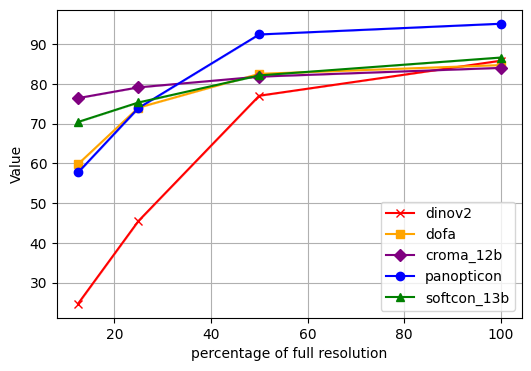

also_train/m-eurosat_gsdinv


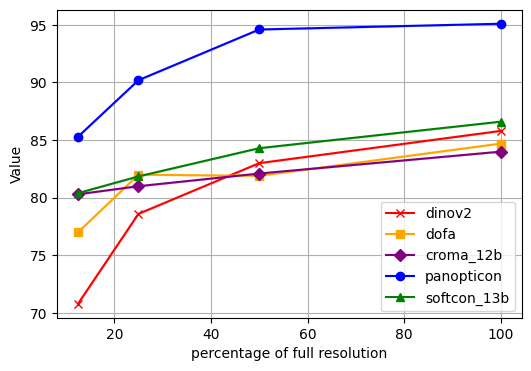

also_train/resisc45_gsdinv


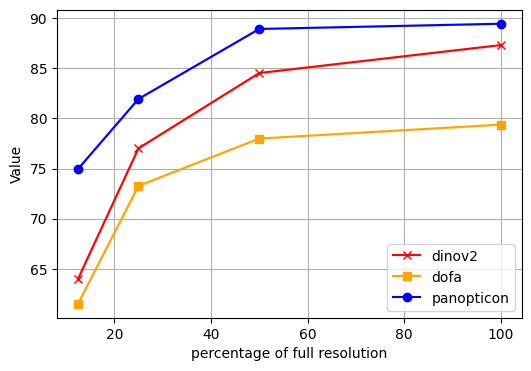

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os


def plot(p):
    collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])

    df = df[df['metric'] == 'acc_top-1_micro']
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['size'] = df['relpath'].apply(lambda x: x.split('/')[1])

    dfplot = df.groupby(['size', 'model'])['val'].agg(['mean', 'std']).reset_index()
    dfplot['size'] = pd.to_numeric(dfplot['size'])
    dfplot.sort_values('size', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    # display(dfplot)


    # Plot mean with ± std as bands
    plt.figure(figsize=(6, 4))

    for model in dfplot['model'].unique():
        model_data = dfplot[dfplot['model'] == model]
        color, marker = get_aestetics(model)
        plt.plot(model_data['size'], model_data['mean'], label=model, color=color, marker=marker)
        plt.fill_between(model_data['size'], 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2,
                        color=color )
        
    plt.xlabel('percentage of full resolution')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv'
folders = [
    'only_val/m-eurosat_gsdinv',
    'also_train/m-eurosat_gsdinv',
    'also_train/resisc45_gsdinv',
]

for folder in folders:
    print(folder)
    plot(os.path.join(root, folder))

### Spectral invariance

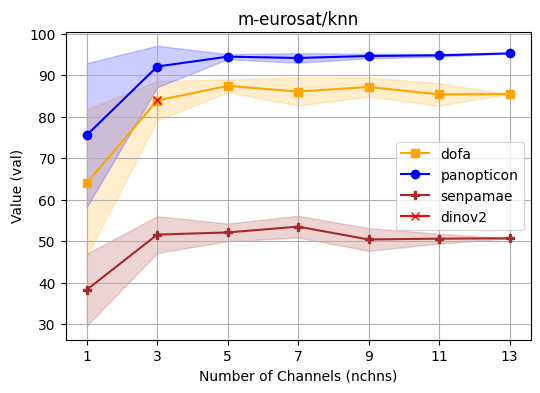

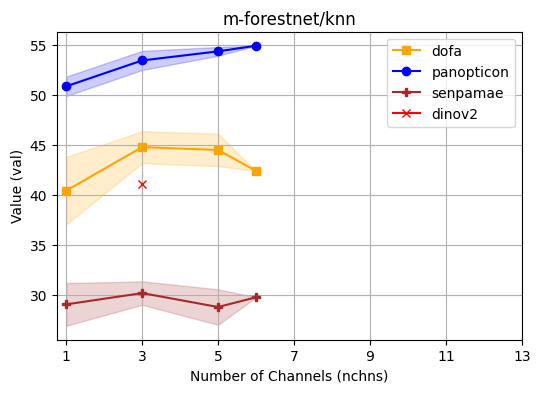

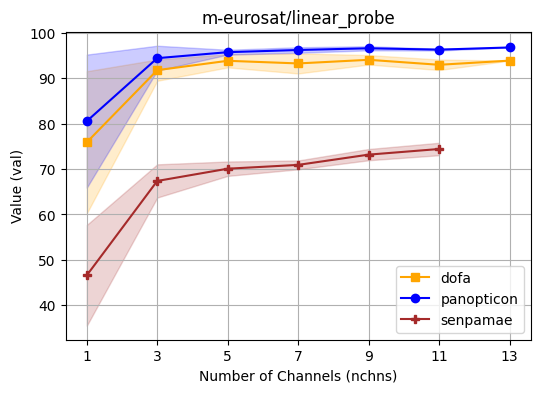

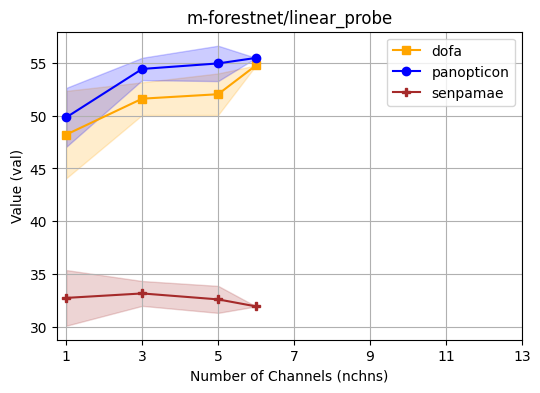

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'

def plot_spec_inv(ds_name):
    p = os.path.join(root, ds_name)
    collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == 'acc_top-1_micro']
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])


    dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std']).reset_index()
    dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
    dfplot.sort_values('nchns', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    if dfplot['mean'].max() <= 1.0:
        dfplot['mean'] = dfplot['mean']*100
        dfplot['std'] = dfplot['std']*100


    # Plot mean with ± std as bands
    plt.figure(figsize=(6, 4))

    for model in dfplot['model'].unique():
        model_data = dfplot[dfplot['model'] == model]
        color, marker = get_aestetics(model)

        plt.plot(model_data['nchns'], model_data['mean'], label=model, color=color, marker=marker)
        plt.fill_between(model_data['nchns'], 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2, 
                        color=color)
        
    plt.title(ds_name)
    plt.xlabel('Number of Channels (nchns)')
    plt.xticks(ticks=range(1, 14, 2))
    plt.ylabel('Value (val)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_spec_inv('m-eurosat/knn')
plot_spec_inv('m-forestnet/knn')
plot_spec_inv('m-eurosat/linear_probe')
plot_spec_inv('m-forestnet/linear_probe')

In [13]:
""" generate random channel combinations"""

import numpy as np
import math

all_chns = 6
n_chns = [1,3,5,6]
subsets_per_n_chns = 5

for chn in n_chns:
    already_used = set()
    n_subsets = min(
        subsets_per_n_chns, 
        math.factorial(all_chns) // (math.factorial(all_chns - chn) * math.factorial(chn)))
    for _ in range(n_subsets):
        def sample():
            l = np.random.choice(range(all_chns), chn, replace=False).tolist()
            l = sorted(l)
            return tuple(l)

        chns = sample()
        while chns in already_used:
            chns = sample()
        already_used.add(chns)

        print(f'  \"{chn:2d} {str(list(chns)).replace(" ","")}\"')

  " 1 [3]"
  " 1 [5]"
  " 1 [1]"
  " 1 [0]"
  " 1 [2]"
  " 3 [2,4,5]"
  " 3 [2,3,5]"
  " 3 [2,3,4]"
  " 3 [0,1,2]"
  " 3 [0,1,4]"
  " 5 [1,2,3,4,5]"
  " 5 [0,1,2,4,5]"
  " 5 [0,1,2,3,4]"
  " 5 [0,1,3,4,5]"
  " 5 [0,1,2,3,5]"
  " 6 [0,1,2,3,4,5]"


In [1]:
from omegaconf import OmegaConf, open_dict
from geobreeze.factory import make_model

p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/config/model/base/panopticon.yaml'
cfg = OmegaConf.load(p)
with open_dict(cfg):
    cfg.blk_indices = cfg.blk_indices.linear_probe
model = make_model(cfg)

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/pano

Loaded encoder with blocks [8, 9, 10, 11] blocks and norm LayerNorm((768,), eps=1e-06, elementwise_affine=True)


In [2]:
from geobreeze.factory import make_dataset
from omegaconf import OmegaConf

p = '/home/hk-project-pai00028/tum_mhj8661/code/segm_test.yaml'
cfg = OmegaConf.load(p)

ds = make_dataset(cfg.data.train, normalize=False)
x_dict, mask = ds[0]

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


{'_target_': 'K.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.Resize', 'size': 224, 'keepdim': True}


In [4]:
ds[0][0].keys()

dict_keys(['imgs', 'chn_ids'])

In [5]:
ds.calibrate(band_ids=[1,4,5])

INFO:eval:Subsampled 3/12 bands with ids [1, 4, 5]. Band names are:
  000: 02 - Blue
  001: 05 - Vegetation Red Edge
  002: 06 - Vegetation Red Edge


In [6]:
ds[0][0]['imgs'].shape

torch.Size([3, 224, 224])

In [7]:
ds[0][0]['chn_ids']

tensor([492.9971, 704.0059, 740.5521])

In [2]:
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
os.listdir(root)

['rfs_sentinel2_a.npy',
 'rfs_modis_terra.npy',
 'rfs_enmap_recon.npy',
 'rfs_wv23_recon.npy',
 'rfs_sentinel2_b.npy',
 'rfs_sentinel2_a_13b.npy',
 'rfs_landsat.npy',
 'rfs_superdove.npy']

In [5]:
import numpy as np

srfs = {}
for f in os.listdir(root):
    if f.endswith('.npy'):
        data = np.load(os.path.join(root,f))
        srfs[f.removesuffix('.npy')] = data

for f, d in srfs.items():
    print(f, d.shape)

rfs_sentinel2_a (2301, 10)
rfs_modis_terra (2301, 16)
rfs_enmap_recon (2301, 224)
rfs_wv23_recon (2301, 8)
rfs_sentinel2_b (2301, 10)
rfs_sentinel2_a_13b (2301, 13)
rfs_landsat (2301, 7)
rfs_superdove (2301, 8)


In [13]:
f1 = 'rfs_sentinel2_a'
f2 = 'rfs_sentinel2_a_13b'

out = np.ones([srfs[f1].shape[1], srfs[f2].shape[1]]) * -1
for i in range(srfs[f1].shape[1]):
    for j in range(srfs[f2].shape[1]):
        out[i,j] = np.allclose(srfs[f1][:,i], srfs[f2][:,j]) 

print(out)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
ds.calibrate(band_ids= None)

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


In [9]:
metainfo = {
    'chn_ids': 'bands.gaussian.mu',
    'gsd': 'bands.GSD',
    'senpamae_srf_name': 'senpamae_srf_name'
}
ds.calibrate(metainfo=metainfo)

ds[0]

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


({'imgs': tensor([[[ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           ...,
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001]],
  
          [[ 394.0000,  390.2780,  374.5471,  ...,  564.1841,  501.8976,
             480.0002],
           [ 403.7175,  376.9169,  374.3644,  ...,  522.4305,  516.6534,
             439.7141],
           [ 410.8700,  396.7253,  372.7646,  ...,  501.2694,  462.4356,
             443.7401],
           ...,
           [ 354.8159,  344.2336,  358.6949,  ...,  350.4633,  322.1515,
          

torch.Size([12, 224, 224])
torch.Size([224, 224])


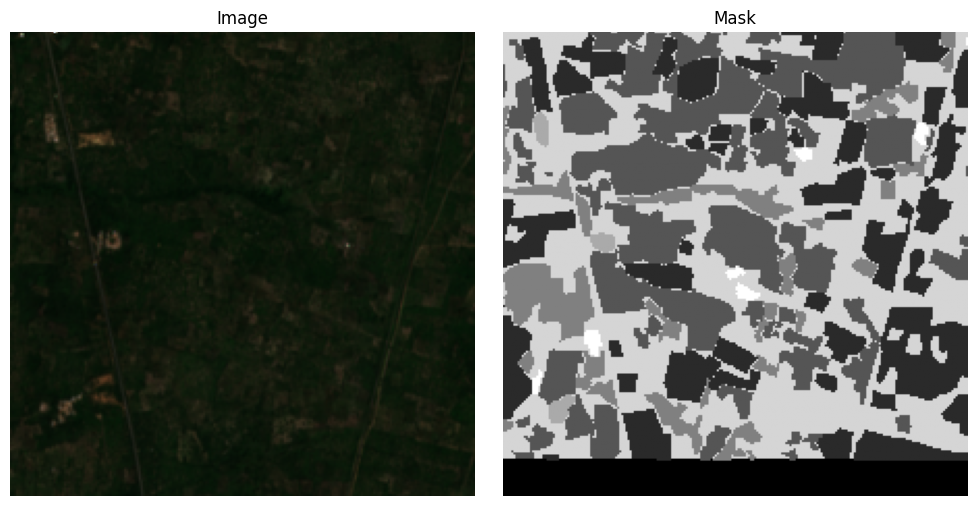

torch.Size([12, 224, 224])
torch.Size([224, 224])


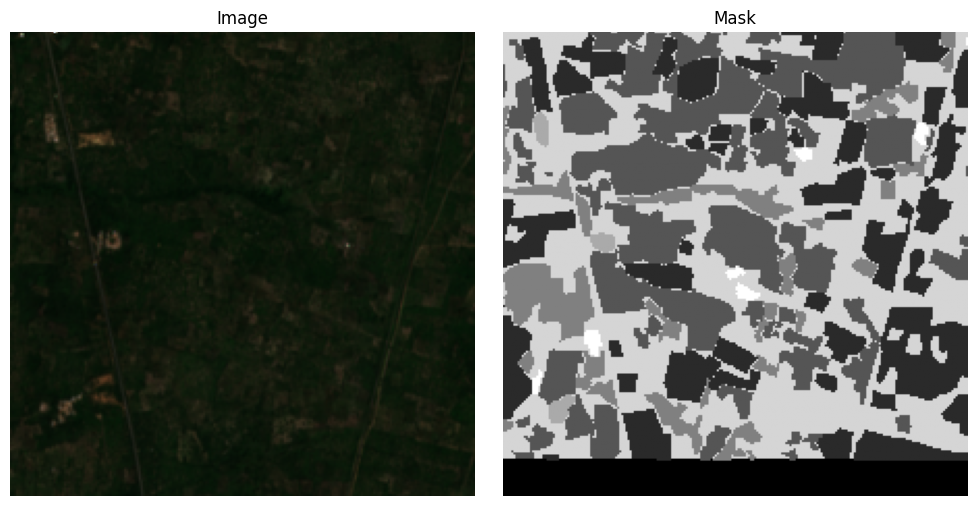

In [16]:
x_dict, mask = ds[100]


img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()



img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
ds.dataset[0].bands

[Band(info=Band 01 - Coastal aerosol (60.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 02 - Blue (10.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 03 - Green (10.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 04 - Red (10.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 05 - Vegetation Red Edge (20.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 06 - Vegetation Red Edge (20.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 07 - Vegetation Red Edge (20.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 08 - NIR (10.0m resolution), shape=(256, 256), resampled_resolution=0.5m, date=2019-11-15),
 Band(info=Band 08A - Vegetation Red Edge (20.0m resolution), shape=(256,

In [11]:
import kornia as K
import torch

trf = K.augmentation.AugmentationSequential(
    K.augmentation.RandomVerticalFlip(p=1),
    data_keys=['input', 'label'],
)

x = torch.tensor([[1,1],[2,2,]], dtype=torch.float32)
y = torch.tensor([1], dtype=torch.int64)

print(x)

trf(x, y)   

tensor([[1., 1.],
        [2., 2.]])


[tensor([[[[2., 2.],
           [1., 1.]]]]),
 tensor([1])]

In [ ]:
trf.

[<DataKey.IMAGE: 0>, <DataKey.LABEL: 6>]

In [12]:
ds[0]

TypeError: Sequential.forward() takes 2 positional arguments but 3 were given

In [27]:
from geobreeze.factory import make_dataset
from omegaconf import OmegaConf

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/debug/eval/1/k=None_T=None_norm=None/config.yaml'
cfg = OmegaConf.load(p)

ds = make_dataset(cfg.data.train)

{'_target_': 'K.RandomHorizontalFlip', 'p': 0.5}
{'_target_': 'K.RandomVerticalFlip', 'p': 0.5}
{'_target_': 'K.Resize', 'size': 224, 'keepdim': True}


In [32]:
ds[0][0]['imgs'].shape

torch.Size([1, 3, 224, 224])

In [4]:
sample = ds.dataset[0]

In [6]:
x, band_names = sample.pack_to_3d(
            band_names=None,
            resample=False,
            fill_value=None,
            resample_order=3,)

In [9]:
import torch
x = torch.from_numpy(x.astype("float32")).permute(2, 0, 1)
x.shape

torch.Size([3, 320, 320])

In [10]:
ds.transform

Sequential(
  (0): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
  (1): RandomVerticalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
  (2): RandomResizedCrop(scale=[0.8, 1.0], resize_to=(0.75, 1.3333333333333333), output_size=[224, 224], p=1.0, p_batch=1.0, same_on_batch=False, size=[224, 224], resample=bilinear, align_corners=True, cropping_mode=slice, padding_mode=zeros)
)

In [11]:
ds[0]

TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [14]:
ds.transform[0]

RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False)

In [35]:
import kornia.augmentation as K

x = torch.randn(3,224,224)
K.RandomHorizontalFlip(p=0.5, keepdim=True)(x).shape

torch.Size([3, 224, 224])

In [26]:
import kornia.augmentation as K

augm = K.RandomResizedCrop(
    size=[224, 224],
    scale=[0.08, 1.0],
)

augm(torch.randn(3,20,20))

tensor([[[[-0.6115, -0.5512, -0.4908,  ...,  0.0644,  0.0038, -0.0569],
          [-0.6548, -0.5952, -0.5357,  ...,  0.1033,  0.0449, -0.0134],
          [-0.6980, -0.6393, -0.5807,  ...,  0.1421,  0.0861,  0.0301],
          ...,
          [ 1.3174,  1.2933,  1.2693,  ..., -2.0553, -2.0752, -2.0950],
          [ 1.3602,  1.3345,  1.3088,  ..., -2.1427, -2.1649, -2.1871],
          [ 1.4030,  1.3756,  1.3482,  ..., -2.2300, -2.2546, -2.2792]],

         [[ 0.5719,  0.5066,  0.4413,  ..., -0.0731, -0.1169, -0.1608],
          [ 0.5724,  0.5071,  0.4417,  ..., -0.0805, -0.1250, -0.1696],
          [ 0.5729,  0.5075,  0.4422,  ..., -0.0880, -0.1331, -0.1783],
          ...,
          [ 0.0298,  0.0463,  0.0627,  ..., -0.1877, -0.1435, -0.0992],
          [-0.0116,  0.0064,  0.0244,  ..., -0.2128, -0.1665, -0.1202],
          [-0.0530, -0.0335, -0.0140,  ..., -0.2379, -0.1895, -0.1411]],

         [[-0.3400, -0.2405, -0.1410,  ...,  1.3151,  1.4067,  1.4984],
          [-0.3472, -0.2498, -

In [22]:
ds.transform[2](torch.randn(3,20,20))

TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [25]:
import geobench

task_iter = geobench.task_iterator(benchmark_name='classification_v1.0')

tasks = {task.dataset_name: task for task in task_iter}
task = tasks.get('m-eurosat')

In [3]:
task.get_dataset().normalization_stats()

NameError: name 'task' is not defined

In [10]:
from geobreeze.factory import make_dataset

ds = make_dataset(dict(
    _target_ = 'GeoBenchDataset',
    ds_name = 'm-pv4ger',
    split = 'train',
))
ds[0]

({'imgs': tensor([[[[ 1.5981,  1.5981,  1.5981,  ...,  1.3398,  1.1922,  1.1922],
            [ 1.5981,  1.5981,  1.6351,  ...,  1.1922,  1.0077,  1.0077],
            [ 1.5243,  1.6351,  1.6351,  ...,  1.1922,  1.0077,  1.0077],
            ...,
            [ 1.1738,  1.1738,  1.3214,  ..., -0.2839, -0.2839, -0.2839],
            [ 0.9708,  0.9708,  1.2476,  ..., -0.2839, -0.2839, -0.2839],
            [ 0.9708,  0.9708,  1.2476,  ..., -0.3577, -0.3577, -0.3761]],
  
           [[ 1.5397,  1.5397,  1.5397,  ...,  1.2497,  1.0841,  1.0841],
            [ 1.5397,  1.5397,  1.5604,  ...,  1.0841,  0.8977,  0.8977],
            [ 1.5190,  1.5604,  1.5604,  ...,  1.0841,  0.8977,  0.8977],
            ...,
            [ 1.1462,  1.1462,  1.2912,  ..., -0.1793, -0.1793, -0.1793],
            [ 0.9598,  0.9598,  1.2290,  ..., -0.1793, -0.1793, -0.1793],
            [ 0.9598,  0.9598,  1.2290,  ..., -0.2208, -0.2208, -0.2622]],
  
           [[ 1.5530,  1.5530,  1.5530,  ...,  1.2172,  1.0605

In [13]:
ds.dataset.list_splits()

['train', 'valid', 'test']